In [0]:

from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
"""
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle datasets download -d skooch/ddsm-mammography
!ls
!unzip ddsm-mammography.zip 
"""

'\nos.environ[\'KAGGLE_CONFIG_DIR\'] = "/content/gdrive/My Drive/Kaggle"\n!kaggle datasets download -d skooch/ddsm-mammography\n!ls\n!unzip ddsm-mammography.zip \n'

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator
import sklearn.utils
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

import keras
import os
from __future__ import division


Using TensorFlow backend.


In [0]:
epochs = 20
batch_size = 30
datasize = 59890#size od used dataset(DDSM from Kaggle)
steps_per_epoch=int(59890 / float(batch_size))

In [0]:
#changing the working directory
!pwd
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content
/content/gdrive/My Drive/Kaggle


In [0]:
trainpaths = ["training10_0/training10_0.tfrecords","training10_1/training10_1.tfrecords","training10_2/training10_2.tfrecords","training10_3/training10_3.tfrecords"]

In the below piece of code, the training data in tfrecords are turn into a dataset object

In [0]:

import gc
def read_tfrecord(proto):
    features = tf.compat.v1.parse_single_example(
        proto,
        features={
            'label_normal': tf.io.FixedLenFeature([], tf.int64),
            'image': tf.io.FixedLenFeature([], tf.string)
        })
    # now return the converted data
    label = features['label_normal']
    image = tf.io.decode_raw(features['image'], tf.uint8)


    image = tf.cast(image,tf.float32)/255.
    image = tf.reshape(image, [299, 299, 1])
    image = tf.image.per_image_standardization(image)

    gc.collect()
    return image, label
#source code from https://androidkt.com/feed-tfrecord-to-keras/
"""
def get_batched_dataset(filenames):
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(batch_size) 
  return dataset
dataset = get_batched_dataset(trainpaths)
print(dataset)

"""

def get_batched_dataset(filenames):
  fractions = [0.86, 0.14]
  class_func = lambda a,b:b
  resampler = tf.data.experimental.rejection_resample(
  class_func, target_dist=[0.5, 0.5], initial_dist=fractions)
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord)
  """
  dataset = dataset.apply(resampler)
  dataset = dataset.map(lambda extra_feature, feature_and_label: feature_and_label)
  """
  dataset = dataset.repeat()
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(batch_size) 
  return dataset
dataset = get_batched_dataset(trainpaths)
print(dataset)


<BatchDataset shapes: ((None, 299, 299, 1), (None,)), types: (tf.float32, tf.int64)>


In [0]:
#Basic image visualization, label
#image_batch, label_batch = dataset.__iter__().next()
#print(type(image_batch))
"""
from google.colab.patches import cv2_imshow
iarr = image_batch.numpy()
print(iarr.shape)
i=iarr[0]
print(i.shape)
cv2_imshow(i)
print(label_batch)
"""


'\nfrom google.colab.patches import cv2_imshow\niarr = image_batch.numpy()\nprint(iarr.shape)\ni=iarr[0]\nprint(i.shape)\ncv2_imshow(i)\nprint(label_batch)\n'

In the below piece of code, testing data is loaded into memory as a numpy array. Test and validation sets are combined, because the Kaggle author split validation and test sets wrong while putting the ddsm.

In [0]:
X_test1 = np.load('test10_data/test10_data.npy')
X_test2 = np.load('cv10_data/cv10_data.npy')

y_test1 = np.load("test10_labels.npy")
y_test2 = np.load("cv10_labels.npy")
X_test = np.concatenate((X_test1,X_test2),axis = 0)


X_test = X_test[:1000]
X_test = X_test/255.
X_test = tf.convert_to_tensor(X_test)
#X_test = tf.image.per_image_standardization(X_test)
X_test = X_test.numpy()
y_test = np.concatenate((y_test1,y_test2),axis = 0)
y_test = np.array((list(map(lambda x: 0 if x == 0 else 1,y_test))))
weights = sklearn.utils.class_weight.compute_class_weight('balanced',np.array([0,1]), y_test)
y_test = y_test[:1000]
datagen = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
datagen.fit(X_test)
#I used the code below to test neural network with the test set
"""


X_test_negative_filter = list(map(lambda x: True if x == 0 else False,y_test))
X_test_positive_filter = list(map(lambda x: False if x == 0 else True,y_test))

X_test_positive = X_test[X_test_positive_filter]
X_test_negative = X_test[X_test_negative_filter]
print(X_test_positive.shape)
print(X_test_negative.shape)
X_test_negative = X_test_negative[:855]
X = np.concatenate((X_test_negative,X_test_positive),axis = 0)
y_negative= np.zeros(shape = (855,))
y_positive= np.ones(shape = (855,))
y = np.concatenate((y_negative,y_positive),axis = 0)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(np.sum(y))
"""

'\n\n\nX_test_negative_filter = list(map(lambda x: True if x == 0 else False,y_test))\nX_test_positive_filter = list(map(lambda x: False if x == 0 else True,y_test))\n\nX_test_positive = X_test[X_test_positive_filter]\nX_test_negative = X_test[X_test_negative_filter]\nprint(X_test_positive.shape)\nprint(X_test_negative.shape)\nX_test_negative = X_test_negative[:855]\nX = np.concatenate((X_test_negative,X_test_positive),axis = 0)\ny_negative= np.zeros(shape = (855,))\ny_positive= np.ones(shape = (855,))\ny = np.concatenate((y_negative,y_positive),axis = 0)\nX_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)\nprint(np.sum(y))\n'

In [0]:
print(weights)

[0.575      3.83333333]


We are planning to do binary classification, however the test set is labeled with 5 classes. In the below code this 5 class labeling is reduced to the two classes "positive" and "negative"

In [0]:
print(y_test[:10])
print(y_test_reduced[:10])
print(X_test[0:10])

In [0]:
#garbage collection code
"""
del model
import gc
gc.collect()
"""

'\ndel model\nimport gc\ngc.collect()\n'

Below code imports machine learning libraries

In [0]:
#y_test_reduced = np.array([0,0,0,0,0,0,0,0,0,0])

In [0]:
import tensorflow.keras.applications
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization,Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow.keras.metrics
from tensorflow.keras import Sequential

In [0]:
"""
#VGG16 with 3 dense layers and 0.7 dropouts between.
model = Sequential()
model.add(Conv2D(input_shape=(299,299,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.70))
model.add(Dense(units=64,activation="relu"))
model.add(Dropout(0.70))
model.add(Dense(units=1, activation="sigmoid"))
model.summary()
"""

#VGG16 with 3 dense layers, batch normalization between layers and activation functions and 0.7 dropouts in fully connected layers.
model = Sequential()
model.add(Conv2D(input_shape=(299,299,1),filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.70))
model.add(Dense(units=64,activation="relu"))
model.add(Dropout(0.70))
model.add(Dense(units=1, activation="sigmoid"))
model.load_weights('vgg16bnus.h5')
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 299, 299, 64)      640       
_________________________________________________________________
batch_normalization_26 (Batc (None, 299, 299, 64)      256       
_________________________________________________________________
activation_26 (Activation)   (None, 299, 299, 64)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 299, 299, 64)      36928     
_________________________________________________________________
batch_normalization_27 (Batc (None, 299, 299, 64)      256       
_________________________________________________________________
activation_27 (Activation)   (None, 299, 299, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 149, 149, 64)     

In [0]:
truepositive = tf.keras.metrics.TruePositives()
truenegative = tf.keras.metrics.TrueNegatives()
falsepositive = tf.keras.metrics.FalsePositives()
falsenegative = tf.keras.metrics.FalseNegatives()

In [0]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
MyAdamW = tfa.optimizers.extend_with_decoupled_weight_decay(tf.keras.optimizers.Adam)
adamw = MyAdamW(weight_decay=0.001, learning_rate=0.001)
model.compile(optimizer=adam,loss='binary_crossentropy',metrics = ['accuracy',truepositive,truenegative,falsepositive,falsenegative])


In [0]:
checkpoint = ModelCheckpoint("vgg16bnus3.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

#history = model.fit(X_train,y_train,epochs=1, validation_data = (X_test, y_test),callbacks=[checkpoint,early])
class_weight = {0: 0.575, 1: 3.83333333}
#history = model.fit(dataset,steps_per_epoch = steps_per_epoch,epochs=epochs, validation_data = (X_test, y_test),callbacks=[checkpoint,early],class_weight=class_weight)
history = model.fit(dataset,steps_per_epoch = steps_per_epoch,epochs=epochs, validation_data = datagen.flow(X_test, y_test),callbacks=[checkpoint,early],class_weight=class_weight)

#history = model.fit(X_test,y_tes,steps_per_epoch=steps_per_epoch,epochs=10, validation_data = (X_test, y_test_reduced),class_weight=class_weight)

def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

history.history


Epoch 1/20
1996/1996 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.6649 - true_positives_1: 4941.0000 - true_negatives_1: 34872.0000 - false_positives_1: 17177.0000 - false_negatives_1: 2890.0000
Epoch 00001: val_accuracy improved from -inf to 0.76900, saving model to vgg16bnus3.h5
1996/1996 [==============================] - 943s 472ms/step - loss: 0.6804 - accuracy: 0.6649 - true_positives_1: 4941.0000 - true_negatives_1: 34872.0000 - false_positives_1: 17177.0000 - false_negatives_1: 2890.0000 - val_loss: 0.5281 - val_accuracy: 0.7690 - val_true_positives_1: 125.0000 - val_true_negatives_1: 644.0000 - val_false_positives_1: 220.0000 - val_false_negatives_1: 11.0000
Epoch 2/20
1996/1996 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.7527 - true_positives_1: 5593.0000 - true_negatives_1: 39477.0000 - false_positives_1: 12609.0000 - false_negatives_1: 2201.0000
Epoch 00002: val_accuracy improved from 0.76900 to 0.87400, saving model to

{'accuracy': [0.6648797392845154,
  0.752672016620636,
  0.7845858335494995,
  0.7983466982841492,
  0.8268871307373047,
  0.8399131894111633,
  0.8649131655693054,
  0.8760187029838562,
  0.8898463845252991,
  0.8951402902603149,
  0.9042251110076904,
  0.907782256603241,
  0.9140447378158569,
  0.918704092502594,
  0.9254676103591919,
  0.9276553392410278,
  0.9343854188919067,
  0.9427521824836731,
  0.9378089308738708,
  0.9410320520401001],
 'false_negatives_1': [2890.0,
  2201.0,
  1795.0,
  1556.0,
  1398.0,
  1221.0,
  1070.0,
  973.0,
  880.0,
  786.0,
  681.0,
  659.0,
  568.0,
  514.0,
  466.0,
  459.0,
  384.0,
  379.0,
  417.0,
  364.0],
 'false_positives_1': [17177.0,
  12609.0,
  11104.0,
  10519.0,
  8968.0,
  8365.0,
  7019.0,
  6451.0,
  5716.0,
  5493.0,
  5054.0,
  4863.0,
  4579.0,
  4354.0,
  3997.0,
  3873.0,
  3545.0,
  3049.0,
  3307.0,
  3167.0],
 'loss': [0.6803835034370422,
  0.5516506433486938,
  0.4932127296924591,
  0.453572541475296,
  0.415100634098053,

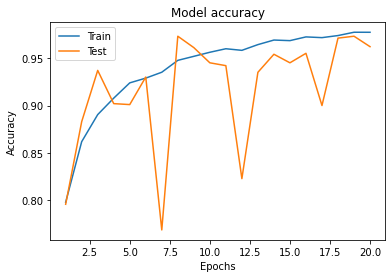

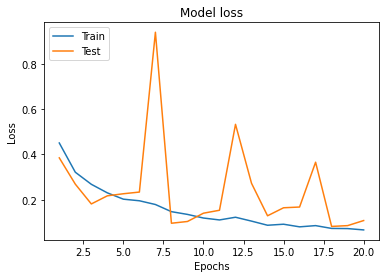

In [0]:
plot_learningCurve(history, epochs)

In [0]:
#X_test = np.concatenate((X_test1,X_test2),axis = 0)
#X_test = X_test[1000:]
#X_test = X_test/255.
#y_test = np.concatenate((y_test1,y_test2),axis = 0)

#y_test = y_test[1000:]
y_test = np.array((list(map(lambda x: 0 if x == 0 else 1,y_test))))
print(y_test.shape)
results = model.evaluate(datagen.flow(X_test,y_test),batch_size=30)
print('test loss, test acc:', results)


(1000,)
32/32 [==============================] - 5s 146ms/step - loss: 0.1545 - accuracy: 0.9520 - true_positives_1: 105.0000 - true_negatives_1: 847.0000 - false_positives_1: 17.0000 - false_negatives_1: 31.0000
test loss, test acc: [0.15452979505062103, 0.9520000219345093, 105.0, 847.0, 17.0, 31.0]


In [0]:
print(y_test[:10])
model.predict_proba(X_test[:10])

[1 0 0 0 0 0 0 0 1 0]
Instructions for updating:
Please use `model.predict()` instead.


array([[9.9998522e-01],
       [1.7808137e-11],
       [2.0956597e-03],
       [1.8778671e-02],
       [1.0558557e-08],
       [1.0146174e-01],
       [3.4153184e-06],
       [5.9975612e-08],
       [9.9738401e-01],
       [3.2516003e-02]], dtype=float32)

In [0]:
"""
#code from https://www.avanwyk.com/finding-a-learning-rate-in-tensorflow-2/
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)
        """

In [0]:
#lr_finder = LRFinder()

model.fit(dataset,steps_per_epoch = steps_per_epoch,epochs=5, validation_data = (X_test, y_test_reduced),callbacks=[lr_finder],verbose = False)
lr_finder.plot()

In [0]:
#lr_finder.plot()